In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 250
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='viridis')
%matplotlib inline

# Data Preprocessing:

In [3]:
df = pd.read_csv("anime.csv")


In [4]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [5]:
# Fill missing numerical values with mean
df['rating'] = df['rating'].fillna(df['rating'].mean())


In [6]:
# Fill missing categorical values
df['genre'] = df['genre'].fillna("Unknown")

In [7]:
df['episodes'] = df['episodes'].replace('Unknown', np.nan).astype(float)
df['episodes'] = df['episodes'].fillna(df['episodes'].median())

In [8]:
df.describe()

,anime_id,episodes,rating,members
count,12294.000000,12294.000000,12294.000000,1.229400e+04
mean,14058.221653,12.095412,6.473902,1.807134e+04
std,11455.294701,46.244062,1.017096,5.482068e+04
min,1.000000,1.000000,1.670000,5.000000e+00
25%,3484.250000,1.000000,5.900000,2.250000e+02
50%,10260.500000,2.000000,6.550000,1.550000e+03
75%,24794.500000,12.000000,7.170000,9.437000e+03
max,34527.000000,1818.000000,10.000000,1.013917e+06


In [9]:
df['genre'].nunique(), df['genre'].unique()

(3265,
 array(['Drama, Romance, School, Supernatural',
        'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
        'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
        ..., 'Hentai, Sports', 'Drama, Romance, School, Yuri',
        'Hentai, Slice of Life'], dtype=object))

In [10]:
# popular anime by rating 
df.sort_values(by="rating", ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1.0,10.00,13
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,2.0,9.60,47
9595,23005,Mogura no Motoro,Slice of Life,Movie,1.0,9.50,62
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1.0,9.33,44
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
10786,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",OVA,1.0,9.25,53
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


Unique Anime Types: ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA' nan]
Unique Genres: ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


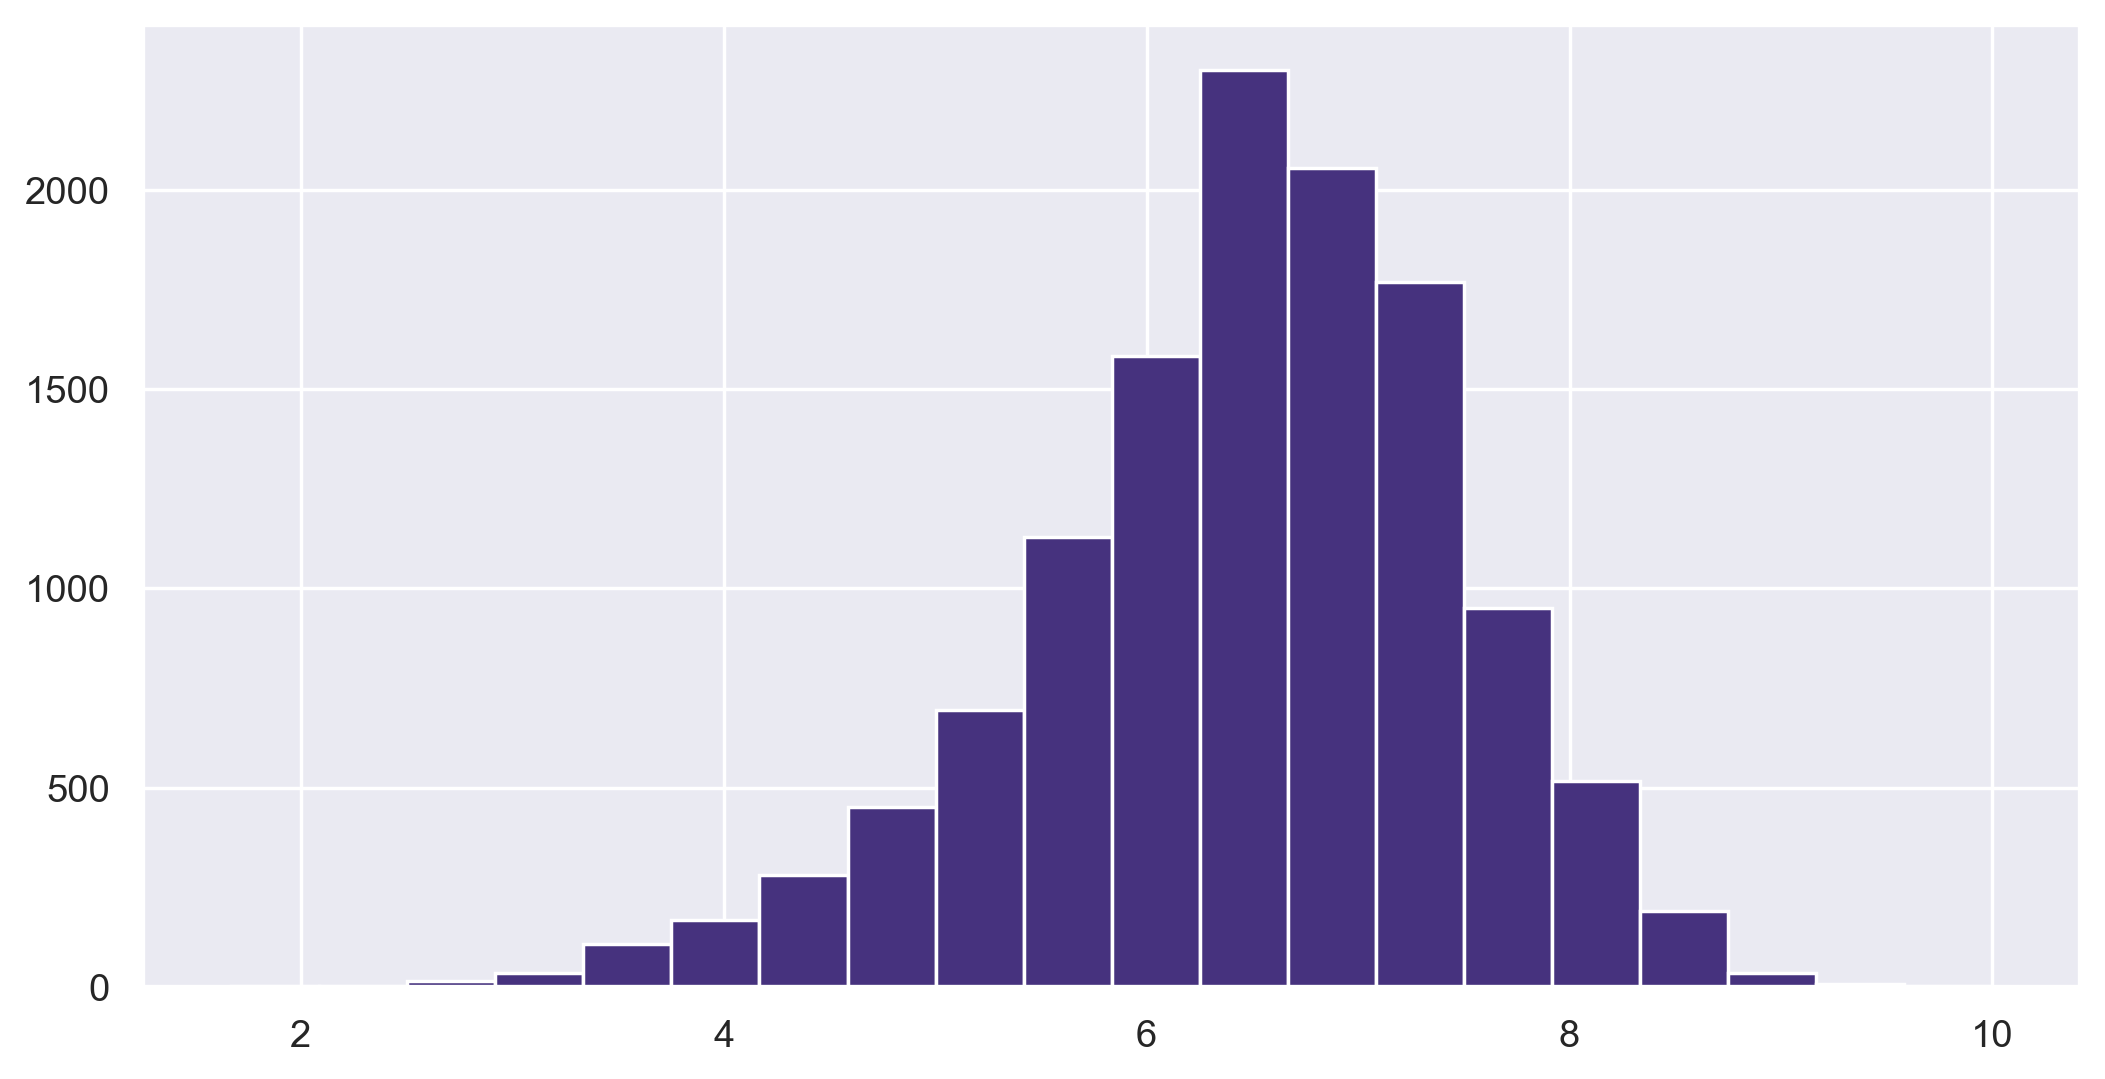

In [11]:
# Unique values in categorical columns (example: genre, type)
print("Unique Anime Types:", df['type'].unique())
print("Unique Genres:", df['genre'].unique())

# Distribution of numerical column (example: rating)
df['rating'].hist(bins=20)
plt.show()

# Feature Extraction:

- focus on genre for main similarity but it can combine rating and episodes for good accuracy.

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

In [13]:
# Split genre string into list
df['genre'] = df['genre'].fillna('Unknown')   # handle NaN
df['genre'] = df['genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])


In [14]:
# One-hot encode genres
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre'])

In [15]:
# Convert to DataFrame
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df.index)


In [16]:
df_features = pd.concat([df, genre_df], axis=1)

In [17]:
from sklearn.preprocessing import LabelEncoder

# Encode 'type' (TV, Movie, OVA, etc.)
df['type'] = df['type'].fillna("Unknown")
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Fill missing numerical values
df['rating'] = df['rating'].fillna(df['rating'].mean())
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce').fillna(df['episodes'].median())
df['members'] = df['members'].fillna(df['members'].median())


In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['rating_norm', 'episodes_norm', 'members_norm']] = scaler.fit_transform(df[['rating', 'episodes', 'members']])


In [19]:
# Select features for similarity
feature_matrix = pd.concat([
    df[['rating_norm', 'episodes_norm', 'members_norm', 'type_encoded']],
    genre_df
], axis=1)

feature_matrix.head()


,rating_norm,episodes_norm,members_norm,type_encoded,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
0,0.924370,0.000000,0.197872,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.911164,0.034673,0.782770,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.909964,0.027518,0.112689,5,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.900360,0.012658,0.664325,5,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.899160,0.027518,0.149186,5,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Recommendation System:

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


In [21]:
# Compute cosine similarity between all anime
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)
cosine_sim

array([[1.        , 0.15611114, 0.06810932, ..., 0.0505523 , 0.05210163,
        0.17306034],
       [0.15611114, 1.        , 0.84239795, ..., 0.83326925, 0.83347238,
        0.06526592],
       [0.06810932, 0.84239795, 1.        , ..., 0.84084626, 0.84105271,
        0.0657609 ],
       ...,
       [0.0505523 , 0.83326925, 0.84084626, ..., 1.        , 0.99999288,
        0.33581756],
       [0.05210163, 0.83347238, 0.84105271, ..., 0.99999288, 1.        ,
        0.33722213],
       [0.17306034, 0.06526592, 0.0657609 , ..., 0.33581756, 0.33722213,
        1.        ]])

In [22]:
def recommend_anime(title, df, similarity_matrix, top_n=10, threshold=0.3):
    # Check if title exists
    if title not in df['name'].values:
        return f"Anime '{title}' not found in dataset."
    
    # Get index of the anime
    idx = df[df['name'] == title].index[0]
    
    # Get similarity scores for this anime
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Remove the anime itself (index 0)
    sim_scores = sim_scores[1:]
    
    # Apply threshold
    sim_scores = [s for s in sim_scores if s[1] >= threshold]
    
    # Select top_n recommendations
    sim_scores = sim_scores[:top_n]
    
    # Get anime names
    anime_indices = [i[0] for i in sim_scores]
    recommendations = df.iloc[anime_indices][['name', 'type', 'rating']].copy()
    recommendations['similarity_score'] = [i[1] for i in sim_scores]
    
    return recommendations
    

In [23]:
recommendations = recommend_anime("Naruto", df, cosine_sim, top_n=5, threshold=0.4)
recommendations

,name,type,rating,similarity_score
615,Naruto: Shippuuden,TV,7.94,0.999415
2458,Naruto Shippuuden: Sunny Side Battle,Special,7.26,0.988809
1103,Boruto: Naruto the Movie - Naruto ga Hokage ni...,Special,7.68,0.988730
175,Katekyo Hitman Reborn!,TV,8.37,0.980784
7628,Kyutai Panic Adventure!,Special,5.21,0.971895


# Evaluation

In [24]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [25]:
train_df.shape

(9835, 11)

In [26]:
test_df.shape

(2459, 11)

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_recommender(test_df, df, similarity_matrix, top_n=10, threshold=0.3):
    precisions, recalls, f1s = [], [], []
    
    for title in test_df['name'].sample(100, random_state=42):  # sample 100 for evaluation
        recs = recommend_anime(title, df, similarity_matrix, top_n=top_n, threshold=threshold)
        
        if isinstance(recs, str):  # if anime not found
            continue
        
        # Get target genres
        target_genres = set(df[df['name'] == title]['genre'].values[0])
        
        # Compute relevance: 1 if recommended anime shares any genre
        y_true = []
        y_pred = []
        
        for _, row in recs.iterrows():
            rec_genres = set(df[df['name'] == row['name']]['genre'].values[0])
            relevant = 1 if len(target_genres.intersection(rec_genres)) > 0 else 0
            y_true.append(1)  # all recommendations are candidates
            y_pred.append(relevant)
        
        # Precision, Recall, F1
        if sum(y_pred) > 0:
            precisions.append(precision_score(y_true, y_pred))
            recalls.append(recall_score(y_true, y_pred))
            f1s.append(f1_score(y_true, y_pred))
    
    return {
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-score": np.mean(f1s)
    }


In [28]:
metrics = evaluate_recommender(test_df, df, cosine_sim, top_n=10, threshold=0.3)
print(metrics)


{'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0}


- From above ,getting same value because genere representation issue and if not remove anime from recommdation it always perfectly match

# Interview Questions:


##  Q1. Can you explain the difference between user-based and item-based collaborative filtering?

## Difference Between User-Based and Item-Based Collaborative Filtering

### 1. **User-Based Collaborative Filtering**
- **Idea**: Find users who are similar to the target user (based on their past ratings or preferences) and recommend items that those similar users liked.
- **Example**: 
    - If User A and User B have watched and liked many of the same anime, 
      and User B liked "Naruto", then recommend "Naruto" to User A.
- **Pros**:
    - Easy to understand and implement.
- **Cons**:
    - Struggles when there are many users with sparse data (cold start problem for new users).

---

### 2. **Item-Based Collaborative Filtering**
- **Idea**: Find items (anime) that are similar to the ones the target user has already liked, and recommend those.
- **Example**:
    - If "Naruto" and "Bleach" are rated similarly by many users, 
      and the target user liked "Naruto", then recommend "Bleach".
- **Pros**:
    - More stable than user-based because item similarities change less often than user similarities.
- **Cons**:
    - Still requires enough ratings to find item similarities.



## Q2. What is Collaborative Filtering and How Does It Work?

### **Definition**
Collaborative Filtering (CF) is a recommendation technique that predicts a user's interests 
by collecting preferences or taste information from many users 
and finding patterns of similarity.

The main idea: **"People who agreed in the past will agree in the future."**

---

### **Works**
1. **Collect Data**  
   - Gather user–item interaction data (e.g., ratings, likes, watch history).
   - Example: Users rating anime from 1–10.

2. **Find Similarities**  
   - Measure similarity between users (User-Based CF) or between items (Item-Based CF).
   - Common similarity measures:  
     - Cosine Similarity  
     - Pearson Correlation

3. **Generate Recommendations**  
   - **User-Based CF**: Recommend items liked by similar users.  
   - **Item-Based CF**: Recommend items similar to those the user liked.


---

### **Types of Collaborative Filtering**
1. **User-Based CF** – Find similar users and recommend what they liked.  
2. **Item-Based CF** – Find similar items and recommend items similar to those liked by the user.

---

### **Pros**
- No need for item content or descriptions — works only with ratings/history.
- Can discover surprising recommendations outside of the user's usual preferences.

### **Cons**
- Cold start problem: New users or new items have no rating history.
- Sparse data can make finding similarities difficult.


